<a href="https://colab.research.google.com/github/juliolunamoreno/First_Challenge/blob/master/Konfio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instructions to replicate this notebook

### In order to be able to replicate this work  yow will have to run "Necessary libraries for data analysis" and all the block "Functions for Analysis and Data Manipulation" afters this you won't have any problems to follow along this notebook

# Necessary libraries for data analisys

In [0]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display
from statsmodels.stats.proportion import proportions_ztest
plt.style.use('seaborn')
import warnings
import datetime
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold,cross_val_score,train_test_split
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor,KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,roc_auc_score,roc_curve,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier,MLPRegressor

# Functions for analysis and data manipulation

In [0]:
def Benchmark(models,X,y,scoring='roc_auc',cv=3,return_resultados=True):
    names,roc,cv_min,cv_max,cv_score=[],[],[],[],[]
  
  
    for model in models:
        names.append(str(model)[:str(model).find('(')])
  
    for model in models:
        model.fit(X,y)
        cv_score.append(np.mean(cross_val_score(X=X,y=y,estimator=model,scoring=scoring,cv=cv)))
        cv_min.append(np.min(cross_val_score(X=X,y=y,estimator=model,scoring=scoring,cv=cv)))
        cv_max.append(np.max(cross_val_score(X=X,y=y,estimator=model,scoring=scoring,cv=cv)))
    resultados=pd.DataFrame(data={'CV Score':cv_score,'CV Min':cv_min,'CV max':cv_max},index=names)
    resultados.plot.barh(figsize=(12,8))
    if return_resultados:
        return resultados

In [0]:
def ROCs(models,X,y,test_size=.3):
    
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=12)
    ls=[]
    names=[]

    for model in models:
        names.append(str(model)[:str(model).find('(')])

    plt.figure(figsize=(12,7))
    for name,model in zip(names,models):
        model.fit(X_train,y_train)
        escore=roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
        fpr,tpr,thresshold=roc_curve(y_test,model.predict_proba(X_test)[:,1])
        ls.append(escore)
        plt.plot(fpr,tpr,label=name+ ': '+ str(round(escore,4)))
    plt.plot([0,1],[0,1],'--',color='red',label='Threshold')
      #plt.xlim([0,1])
      #plt.ylim([0,1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc='best')

In [0]:
def FancyImputer(method,df,colum):
    aux=df.dropna(axis=0,how='any')
    X=aux.drop(colum,axis=1)
    y=aux[colum]
    method.fit(X,y)
    Ximp=df[df[colum].isnull()].drop(colum,axis=1).fillna(df.mean())
    return method.predict(Ximp)

In [0]:
def Class_balanced(df,target,mayority_class=0):
    mayority=df[df[target]==mayority_class].sample(df[df[target] !=mayority_class].shape[0])
    minority=df[df[target] != mayority_class]
    balanced=pd.concat([minority,mayority])
    balanced.reset_index(inplace=True)
    return balanced


In [0]:
def Calibrated_classifier(models,method='sigmoid',return_names=True):
    calibrated,names=[],[]
    for model in models:
        names.append(str(model)[:str(model).find('(')])

    for model in models:
        clf=CalibratedClassifierCV(base_estimator=model,method=method)
        calibrated.append(clf)
    if return_names:
        return list(zip(names,calibrated))
    else: 
        return calibrated

In [0]:
def PlotTime(col1,col2):
    plt.figure(figsize=(16,7))

    plt.subplot(1,2,1)
    our_customers[(our_customers.account_opening_year>=2007) & (our_customers.account_opening_year<=2018) & (our_customers.clase==1)].resample('M')[col1].sum().plot(color='green')
    our_customers[(our_customers.account_opening_year>=2007) & (our_customers.account_opening_year<=2018)  & (our_customers.clase==0)].resample('M')[col1].sum().plot(color='red')
    plt.title('Cedit limit of our good and bad customers through time')
    plt.ylabel('Credit limit')

    plt.subplot(1,2,2)
    our_customers[(our_customers.account_opening_year>=2007) & (our_customers.account_opening_year<=2018) & (our_customers.clase==1)].resample('M')[col2].count().plot(color='green')
    our_customers[(our_customers.account_opening_year>=2007) & (our_customers.account_opening_year<=2018)  & (our_customers.clase==0)].resample('M')[col2].count().plot(color='red')
    plt.title('Number of credits owned good and bad customers \n through time')
    plt.ylabel('Number of credits')

    plt.tight_layout()

In [0]:
def BusinessUplot(df,x,y,clase):
    plt.figure(figsize=(16,7))

    p_value_inc=stats.ttest_ind(np.log(df[x][df[clase]==0]),np.log(df[x][df[clase]==1]))[1]
    p_value_out=stats.ttest_ind(np.log(df[y][df[clase]==0]),np.log(df[y][df[clase]==1]))[1]


    plt.subplot(2,2,1)
    sns.kdeplot(data=np.log(df[x][df[clase]==1]),shade=True,color='green')
    sns.rugplot(a=np.log(df[x][df[clase]==1]),color='green',alpha=.3)
    sns.kdeplot(data=np.log(df[x][df[clase]==0]),shade=True,color='red')
    sns.rugplot(a=np.log(df[x][df[clase]==0]),color='red',alpha=.3)
    plt.title('Monthly income of good vs bad customers  \n p-value t : %.4f' % p_value_inc)
    plt.xlabel('Log of monthly income')

    plt.subplot(2,2,2)
    sns.kdeplot(data=np.log(df[y][df[clase]==1]),shade=True,color='green')
    sns.rugplot(a=np.log(df[y][df[clase]==1]),color='green',alpha=.3)
    sns.kdeplot(data=np.log(df[y][df[clase]==0]),shade=True,color='red')
    sns.rugplot(a=np.log(df[y][df[clase]==0]),color='red',alpha=.3)
    plt.title('Monthly outcome of good vs bad customers \n p-value t : %.4f' % p_value_out)
    plt.xlabel('Log of monthly outcome')

    plt.subplot(2,2,3)
    plt.scatter(x=np.log(df[x][df[clase]==1]),y=np.log(df[y][df[clase]==1]),facecolors='none',edgecolors='green')
    plt.title('Monthly Income vs Outcome good customers \n log scled')
    plt.xlabel('Log of monthly income')
    plt.ylabel('Log of monthly outcome')

    plt.subplot(2,2,4)
    plt.scatter(x=np.log(df[x][df[clase]==0]),y=np.log(df[y][df[clase]==0]),facecolors='none',edgecolors='red')
    plt.title('Monthly Income vs Outcome bad customers \n log scaled')
    plt.xlabel('Log of monthly income')
    plt.ylabel('Log of monthly outcome')

    plt.tight_layout()


In [0]:
def Pieplot(a,b,x,y):
    plt.figure(figsize=(12,7))
    count = [a,x]
    nobs = [a+b,x+y]
    stat, pval = proportions_ztest(count, nobs) 

    plt.subplot(1,2,1)
    labels = ['Good customers','Bad customers']
    sizes = [a,b]
    plt.pie(sizes,labels=labels, autopct='%1.1f%%',colors=['palegreen','lightcoral'],explode=(0,.1),)
    plt.title('Distribution of customers that have \n at least one credit with Konfio \n z-test for proportion of good customers : %.4f' % pval)

    plt.subplot(1,2,2)
    labels = ['Good customers','Bad customers']
    sizes = [x,y]
    plt.pie(sizes,labels=labels, autopct='%1.1f%%',colors=['palegreen','lightcoral'],explode=(0,.1),)
    plt.title('Distribution of customers that have \n NO credit with Konfio')

In [0]:
def Logtransformation(df,columna):
    X=df.drop(columna,axis=1)
    return (X+1).apply(np.log)

In [0]:
def FeatureSelection(X,y,models,cv=3,scorer='roc_auc',steps=1):
    names=[]
    features_opt=[]
    for model in models:
        names.append(str(model)[:str(model).find('(')])

    for name,model in zip(names,models):
        rfecv=RFECV(estimator=model,step=steps,scoring=scorer,cv=StratifiedKFold(cv)).fit(X,y)
        features_opt.append(rfecv.n_features_)
        plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_,marker='o',label=name)
    plt.xlabel('Number of features')
    plt.ylabel(scorer)
    plt.legend(loc='best')
    plt.title('Optimal number of features based on '+str(scorer)+ ' is :%d \n' % int(np.mean(features_opt)))

In [0]:
def FeatureSelector(X,y,model,cv=3,scorer='roc_auc',steps=1):
    ls=[]
    rfecv=RFECV(estimator=model,step=steps,scoring=scorer,cv=StratifiedKFold(cv)).fit(X,y)
    for i,col in enumerate(X_log.columns):
        if rfecv.support_[i]:
            ls.append(col)
    return ls 


In [0]:
def Mypipeline(make_pipeline,X):
    X_pipe=make_pipeline.fit_transform(X)
    return pd.DataFrame(data=X_pipe,columns=X.columns)

In [0]:
def Plot2D(X,y):
    X2D=PCA(n_components=2,).fit_transform(X)
    plt.scatter(X2D[:,0],X2D[:,1],c=y,cmap='RdYlGn',alpha=.4)
    plt.xlabel('first component')
    plt.ylabel('second component')
    plt.title('Values of X previously scaled by clase')
    plt.tight_layout()
    plt.colorbar()

In [0]:
def PlotAnomalies(X,return_values=False):
    
    if not return_values:
        outliyers=LocalOutlierFactor().fit_predict(X)
        X2D=PCA(n_components=2,).fit_transform(X)
        plt.scatter(X2D[:,0],X2D[:,1],c=outliyers,cmap='RdGy',alpha=.4)
        plt.xlabel('first component')
        plt.ylabel('second component')
        plt.title('Values of X in 2D to visualize outliers')
        plt.tight_layout()
        plt.colorbar()
    else:
        outliyers=LocalOutlierFactor().fit_predict(X)
        return outliyers


In [0]:
def PlotK(X,n_clusters_test=8):
    
    ls=[]
    for k in range(1,n_clusters_test+1):
        kmeans=KMeans(n_clusters=k).fit(X)
        ls.append(kmeans.inertia_)
    plt.plot(range(1,n_clusters_test+1),ls,marker='o')
    plt.title('K- means inertia for different k')
    plt.xlabel('k-value')
    plt.ylabel('inertia')

In [0]:
def PlotClusterScore(X,n_clusters_test=8):
    
    ls=[]
    for k in range(2,n_clusters_test+1):
        kmeans=KMeans(n_clusters=k).fit(X)
        ls.append(silhouette_score(X,kmeans.labels_))
    plt.plot(range(2,n_clusters_test+1),ls,marker='s',color='red')
    plt.title('Siluhete score for different values of k')
    plt.xlabel('k-value')
    plt.ylabel('score')

In [0]:
def PlotConfusionMatrix(model,X,y):
    y_pred=model.predict(X)
    cm=pd.crosstab(index=y,columns=y_pred,margins=False)
    sns.heatmap(cm,annot=True,cmap='Greens',fmt='g')
    plt.title('Confusion matrix: \n rows: True lable columns: predicted label')

In [0]:
def RiskPlot(df,column,clase):
    plt.figure(figsize=(8,6))
    sns.kdeplot(data=df[column][df[clase]==1],shade=True,color='green')
    sns.rugplot(a=df[column][df[clase]==1],color='green',alpha=.3)
    sns.kdeplot(data=df[column][df[clase]==0],shade=True,color='red')
    sns.rugplot(a=df[column][df[clase]==0],color='red',alpha=.3)
    plt.title('Risk associated to good and bad customers \n Probability ot the customer to payback the loan')
    plt.ylabel('Number of customers')
    plt.xlabel('Probability');

### Files loading

In [0]:
url_users='https://raw.githubusercontent.com/juliolunamoreno/Data/master/users.csv'
url_credit_reports='https://raw.githubusercontent.com/juliolunamoreno/Data/master/credit_reports.csv'
users=pd.read_csv(url_users)
creport=pd.read_csv(url_credit_reports)

### Creation/manipulation of dataframes

In [0]:
# Creating auxiliary columns and new tables
users.rename(columns={'class':'clase'},inplace=True)
users_detail=pd.merge(creport,users,left_on='user_id',right_on='id')
users.drop(['id'],axis=1,inplace=True)
users_detail.drop(['id'],axis=1,inplace=True)
#users['net_income']=users.monthly_income-users.monthly_outcome
users_detail['has_credit_with_us']=users_detail.institution.str.contains('KONFIO')
users_detail['payment_frequency_days']=users_detail.payment_frequency.map({'Mensual':30,'Semanal':7,'Quincenal':15,'Catorcenal':14,
                                                                'Anual':365,'Trimestral':90,'Una sola exhibición':0,'Pago mínimo para cuentas revolventes':0,'Bimestral':60,'Deducción del salario':0})
users_detail['Late']=users_detail.payment_frequency_days*users_detail.number_of_payments_due
users_detail['Late0-30']=users_detail.Late<=30
users_detail['Late31-60']=(users_detail.Late>30)*(users_detail.Late<=60)
users_detail['Late61-90']=(users_detail.Late>60)*(users_detail.Late<=90)
users_detail['Late91-120']=(users_detail.Late>90)*(users_detail.Late<=120)
users_detail['Late121-150']=(users_detail.Late>120)*(users_detail.Late<=150)
users_detail['Late151-worst']=users_detail.Late>150
users_detail['number_of_time_past_due']=users_detail.number_of_payments_due>0
users_detail['hipoteca']=users_detail.account_type=='Hipoteca'
users_detail['Revolvente']=users_detail.account_type=='Revolvente'

#Creating auxiliary tables to summarize business
our_customers_id=pd.DataFrame({'value':users_detail[(users_detail.has_credit_with_us==True)].groupby(['user_id'])['institution'].count()})
#--our_customers_id['indice']=cust.index
our_customers_id['indice']=our_customers_id.index # Fixed issue above
our_customers=users_detail[users_detail.user_id.isin(our_customers_id.indice)]
non_customers=users_detail[~users_detail.user_id.isin(our_customers_id.indice)]

# Only for pie chart
num_good_cust=users_detail[(users_detail.has_credit_with_us==True) & (users_detail.clase==1)].groupby(['user_id'])['institution'].count().shape[0]
num_bad_cust=users_detail[(users_detail.has_credit_with_us==True) & (users_detail.clase==0)].groupby(['user_id'])['institution'].count().shape[0]
num_good_non_cust=non_customers[non_customers.clase==1].groupby('user_id')['institution'].count().shape[0]
num_bad_non_cust=non_customers[non_customers.clase==0].groupby('user_id')['institution'].count().shape[0]

###For date charts##
fecha_apertura_our=[datetime.datetime.strptime(fecha, '%m/%d/%y').date() for fecha in our_customers.account_opening_date]
fecha_apertura_non=[datetime.datetime.strptime(fecha, '%m/%d/%y').date() for fecha in non_customers.account_opening_date]
our_customers.account_opening_date=pd.to_datetime(fecha_apertura_our)
our_customers['account_opening_year']=our_customers.account_opening_date.apply(lambda x: x.year)
our_customers.set_index('account_opening_date',inplace=True)
non_customers.account_opening_date=pd.to_datetime(fecha_apertura_non)
non_customers['account_opening_year']=non_customers.account_opening_date.apply(lambda x: x.year)
non_customers.set_index('account_opening_date',inplace=True)


# Business Understanding

## Insights:
### I) There is a statistically significant difference between  good and bad customers in terms of income an outcome(1) 
###It should be taken into considerantion when analyzing a potential loan for a customer

### II)  Bad and good customers have a similar behave when it comes to net income , both tend to spend more money than the have and surprinsinly we can see that good customer ramain in average in negative nubers

### III) There is a significant difference between the proportion of good customers as seen in Konfio's customers vs non customers. It seems to be a higher proportion of good customers in Konfio as compared with market(2)

##### (1) Acording to t-test at 99% confidence
##### (2) Acording to z-test at 95% confidence

In [22]:
users[['monthly_income','monthly_outcome']][users.clase==0].describe()[1:].T

,mean,std,min,25%,50%,75%,max
monthly_income,57598.982796,246794.110958,1.0,1798.0,6392.0,26213.0,3968998.0
monthly_outcome,45993.135484,333503.957721,1.0,1477.0,5779.0,22822.0,6496313.0


In [23]:
users[['monthly_income','monthly_outcome']][users.clase==1].describe()[1:].T

,mean,std,min,25%,50%,75%,max
monthly_income,177252.871028,596088.175825,14.0,4500.0,22781.0,89652.5,9344842.0
monthly_outcome,193605.448598,722308.692786,38.0,7562.5,34054.0,102071.0,9749651.0


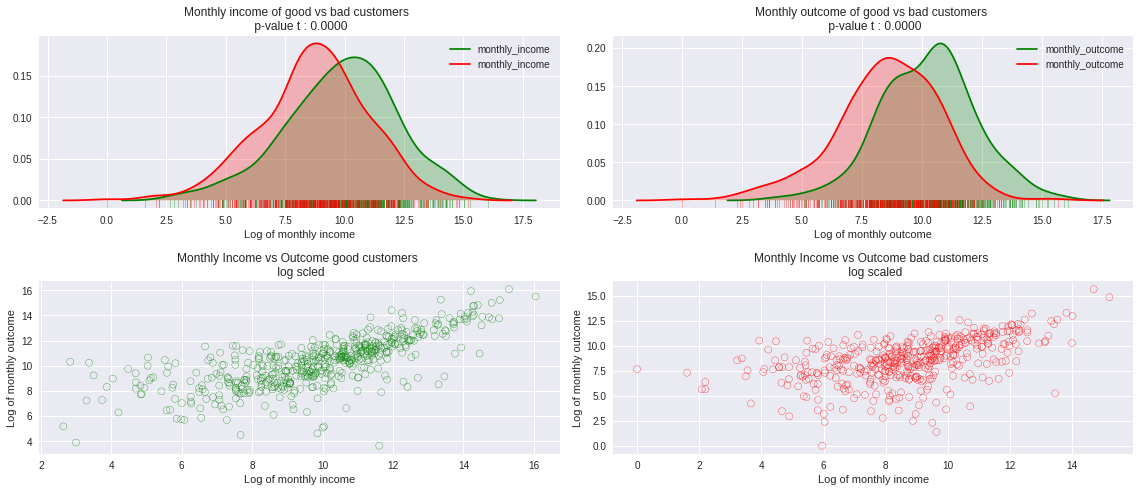

In [24]:
BusinessUplot(users,'monthly_income','monthly_outcome','clase')

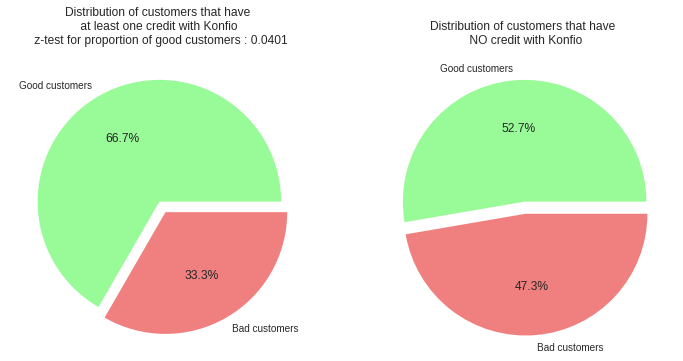

In [25]:
Pieplot(num_good_cust,num_bad_cust,num_good_non_cust,num_bad_non_cust)

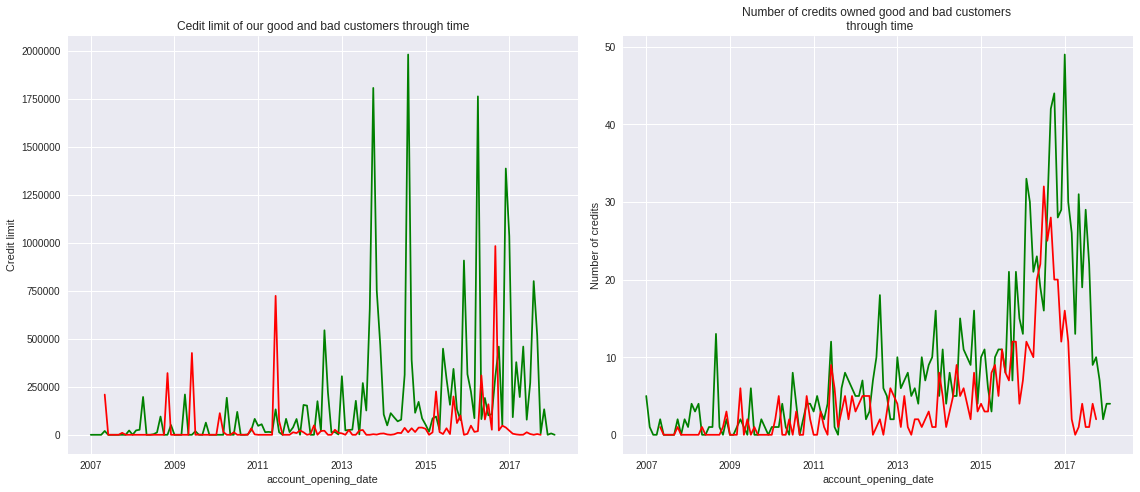

In [26]:
PlotTime('credit_limit','user_id')

# Data Understanding
> ### Variables' shape suggests a logaritmic scaling will be necessary in order to center our variables since most of them are skwed

In [27]:
users_detail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16309 entries, 0 to 16308
Data columns (total 32 columns):
user_id                               16309 non-null int64
institution                           16309 non-null object
account_type                          16309 non-null object
credit_type                           16309 non-null object
total_credit_payments                 16268 non-null float64
payment_frequency                     16308 non-null object
amount_to_pay_next_payment            16304 non-null float64
account_opening_date                  16309 non-null object
account_closing_date                  9068 non-null object
maximum_credit_amount                 16307 non-null float64
current_balance                       16304 non-null float64
credit_limit                          16296 non-null float64
past_due_balance                      16304 non-null float64
number_of_payments_due                16297 non-null float64
worst_delinquency                     16255 no

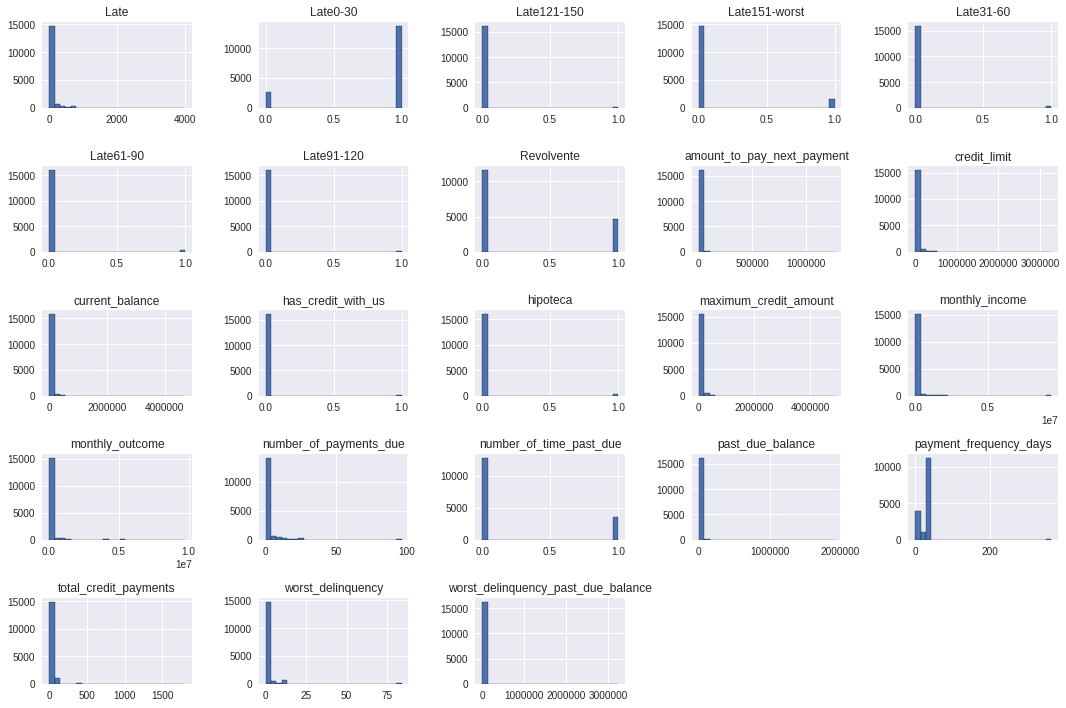

In [28]:
users_detail[users_detail.columns[~users_detail.columns.isin(['clase','user_id'])]].hist(figsize=(15,10),edgecolor='black',bins=25)
plt.tight_layout()

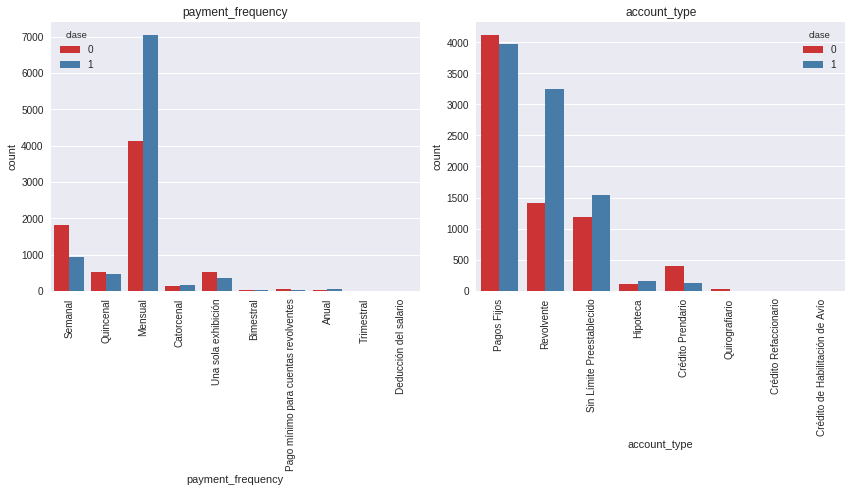

In [29]:
plt.figure(figsize=(12,7))
for i,col in enumerate(users_detail[['payment_frequency','account_type','clase']].columns[0:2]):
    plt.subplot(1,2,i+1)
    sns.countplot(data=users_detail[['payment_frequency','account_type','clase']],x=col,palette='Set1',orient='v',hue='clase')
    plt.title(str(col))
    plt.xticks(rotation=90)
plt.tight_layout()

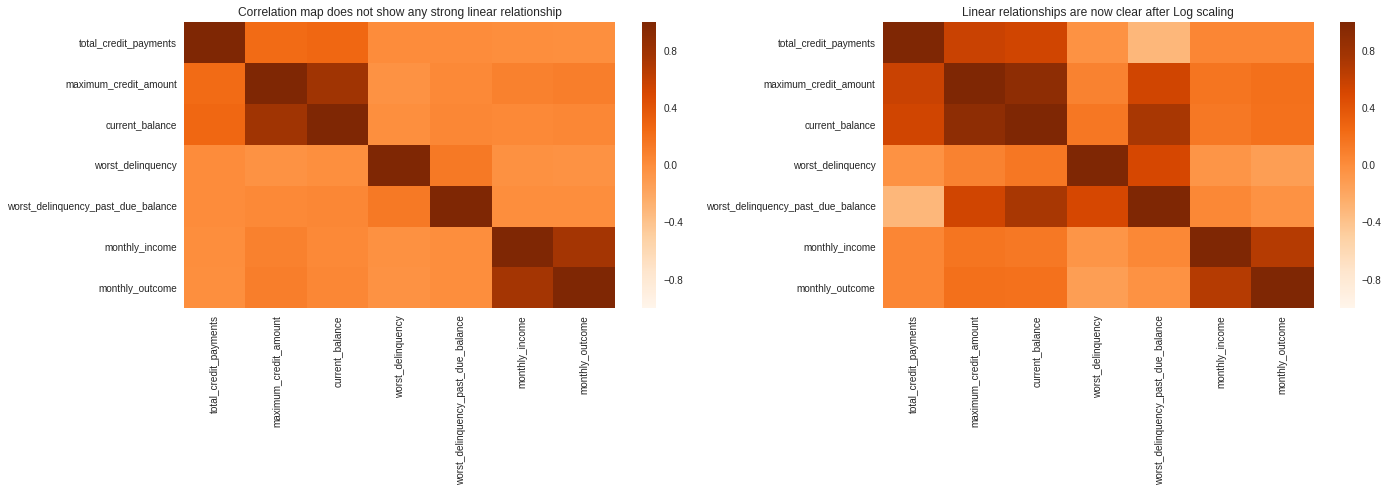

In [30]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
sns.heatmap(users_detail[[ 'total_credit_payments','maximum_credit_amount','current_balance',
                          'worst_delinquency','worst_delinquency_past_due_balance','monthly_income','monthly_outcome']].corr(),cmap='Oranges')
plt.title('Correlation map does not show any strong linear relationship')

plt.subplot(1,2,2)
sns.heatmap(users_detail[[ 'total_credit_payments','maximum_credit_amount','current_balance',
                          'worst_delinquency','worst_delinquency_past_due_balance','monthly_income','monthly_outcome']].apply(np.log).corr(),cmap='Oranges')
plt.title('Linear relationships are now clear after Log scaling')

plt.tight_layout()

# Data Preparation

###New ideally usefull variables (20) will be generated in order to generate a dataset that serves as starting point to create a model that helps to separate good and bad customers

## Variables creation

In [0]:
cliente_konfio=users_detail.groupby('user_id')['has_credit_with_us'].sum().apply(lambda x: x>0)
mean_maximum_credit_amount=users_detail.groupby('user_id')['maximum_credit_amount'].mean()
sum_current_balance=users_detail.groupby('user_id')['current_balance'].sum()
max_credit_limit=users_detail.groupby('user_id')['credit_limit'].max()
mean_worst_delinquency=users_detail.groupby('user_id')['worst_delinquency'].mean()
max_worst_delinquency=users_detail.groupby('user_id')['worst_delinquency'].max()
mean_number_payments_due=users_detail.groupby('user_id')['number_of_payments_due'].mean()
mean_past_due_balance=users_detail.groupby('user_id')['past_due_balance'].mean()
mean_worst_past_due_balance=users_detail.groupby('user_id')['worst_delinquency_past_due_balance'].mean()
number_of_times_late_0_30=users_detail.groupby('user_id')['Late0-30'].sum()
number_of_times_late_31_60=users_detail.groupby('user_id')['Late31-60'].sum()
number_of_times_late_61_90=users_detail.groupby('user_id')['Late61-90'].sum()
number_of_times_late_91_120=users_detail.groupby('user_id')['Late91-120'].sum()
number_of_times_late_121_150=users_detail.groupby('user_id')['Late121-150'].sum()
number_of_times_late_150_worst=users_detail.groupby('user_id')['Late151-worst'].sum()
number_of_open_creditlines_and_loans=users_detail.groupby('user_id')['user_id'].count()
number_of_times_past_due=users_detail.groupby('user_id')['number_of_time_past_due'].sum()
delinquencies_per_line = number_of_times_past_due/number_of_open_creditlines_and_loans
number_of_mortgages=users_detail.groupby('user_id')['hipoteca'].sum()
number_of_revolving_credits=users_detail.groupby('user_id')['Revolvente'].sum()
clase=users.clase
income=users.monthly_income
outcome=users.monthly_outcome
ratio=users.monthly_income/users.monthly_outcome

In [0]:
df=pd.DataFrame({'cliente_konfio':cliente_konfio,'mean_max_cred_amount':mean_maximum_credit_amount,
                 'sum_curr_balance':sum_current_balance,'max_cred_lim':max_credit_limit,
                 'mean_worst_del':mean_worst_delinquency,'max_worst_del':max_worst_delinquency,
                 'mean_num_paymnts_due':mean_number_payments_due,'mean_past_due_balnce':mean_past_due_balance,
                 'mean_worst_past_due_balnce':mean_worst_past_due_balance,'late_0_30':number_of_times_late_0_30,
                 'late_31_60':number_of_times_late_31_60,'late_61_90':number_of_times_late_61_90,'late_91_120':number_of_times_late_91_120,
                 'late_121_150':number_of_times_late_121_150,'late_151_worst':number_of_times_late_150_worst,
                 'num_open_cred_lines_and_loans':number_of_open_creditlines_and_loans,'number_times_past_due':number_of_times_past_due,
                 'delinq_per_line':delinquencies_per_line,'number_mortgages':number_of_mortgages,'number_revolvs':number_of_revolving_credits,'income':income,'outcome':outcome,'ratio':ratio,'clase':clase})
df.cliente_konfio=df.cliente_konfio*1
df.fillna(value=0,axis=1,inplace=True)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
clase                            1000 non-null int64
cliente_konfio                   1000 non-null int64
delinq_per_line                  1000 non-null float64
income                           1000 non-null int64
late_0_30                        1000 non-null float64
late_121_150                     1000 non-null float64
late_151_worst                   1000 non-null float64
late_31_60                       1000 non-null float64
late_61_90                       1000 non-null float64
late_91_120                      1000 non-null float64
max_cred_lim                     1000 non-null float64
max_worst_del                    1000 non-null float64
mean_max_cred_amount             1000 non-null float64
mean_num_paymnts_due             1000 non-null float64
mean_past_due_balnce             1000 non-null float64
mean_worst_del                   1000 non-null float64
mean_worst_past_due_

## Data scaling/transformation
>### Logarithmic transformation will be applied to center data along with standarization and scalin to keep values inside 0,1 this with the objetive of help models to catch more variance and also for helping unsupervised models based on distance becoming more accurate

In [0]:
X_log=Logtransformation(df,'clase')
y=df.clase
X_pipe=Mypipeline(make_pipeline(StandardScaler(),MinMaxScaler()),X_log)

## Feature selection

### By comparing 3 different estimators as well as 3 different metrics to find the best features we can see the following:
>### Since we consider important to minimize false positives we are going to give more weight to roc_auc (true positive rate vs true negative rate)
>### Random Forest is in general having a better performace in term of the 3 metrics so it will be used as base estimator
### By considering the facts described above we have reach the conslusion of keeping 13 variables that give us a roc_auc ~94% and a f1 ~86%

In [0]:
models=[RandomForestClassifier(n_estimators=150,random_state=123),XGBClassifier(random_state=123),LogisticRegression()]

CPU times: user 1min 23s, sys: 412 ms, total: 1min 23s
Wall time: 1min 23s


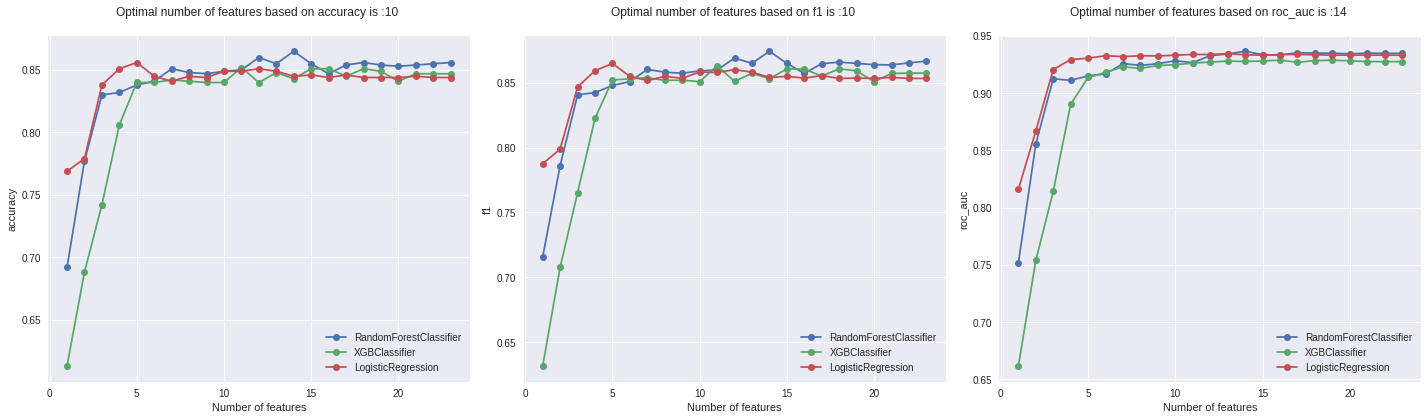

In [36]:
%%time
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
FeatureSelection(X_pipe,y,models,scorer='accuracy',steps=1)
plt.subplot(1,3,2)
FeatureSelection(X_pipe,y,models,scorer='f1',steps=1)
plt.subplot(1,3,3)
FeatureSelection(X_pipe,y,models,scorer='roc_auc',steps=1);
plt.tight_layout()

In [0]:
variables_selected=FeatureSelector(X_pipe,y,RandomForestClassifier(n_estimators=150,random_state=123),scorer='roc_auc',steps=1)

#### Most important variables after feature selection

In [38]:
pd.DataFrame({'best variables':variables_selected})

,best variables
0,delinq_per_line
1,income
2,max_cred_lim
3,max_worst_del
4,mean_max_cred_amount
5,mean_num_paymnts_due
6,mean_past_due_balnce
7,mean_worst_del
8,mean_worst_past_due_balnce
9,num_open_cred_lines_and_loans


In [0]:
X_new=X_pipe[variables_selected]

# Modeling
## We have a classification task that will be resolved by combining tree based models along with neural nets and linear and bayesian models

### Anomally detection

####On the left we have a visualization on 2D of how good and bad costumers have a "well" defined separation
####On the right we have a plot that shows the out and inliyers on our dataset

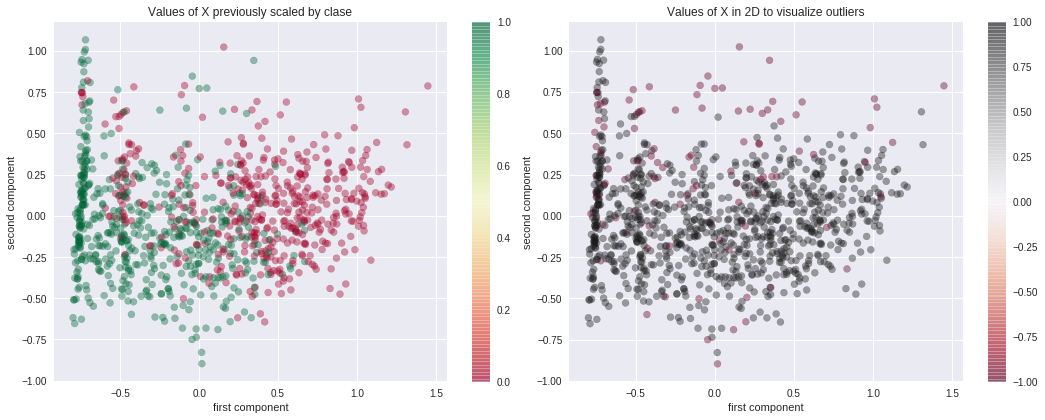

In [40]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
Plot2D(X_new,y)
plt.subplot(1,2,2)
PlotAnomalies(X_new)

In [0]:
outliyers=PlotAnomalies(X_new,return_values=True)

##Model 1: Ensemble methods
> ### Voting classifier

#### Voting classifier

In [0]:
voting=[('nnet',MLPClassifier()),('rf',RandomForestClassifier(n_estimators=150,random_state=123,class_weight='balanced')),
        ('ada',AdaBoostClassifier(random_state=123)),('gnb',GaussianNB()),('lr',LogisticRegression(random_state=123)),
        ('svm',SVC(probability=True,random_state=123))]
Voting=VotingClassifier(estimators=voting,voting='soft')

models=[SVC(probability=True,random_state=123),KNeighborsClassifier(weights='distance'),RandomForestClassifier(n_estimators=150,random_state=123),
        GaussianNB(),LogisticRegression(random_state=123),AdaBoostClassifier(n_estimators=150,random_state=123),MLPClassifier(),Voting]

CPU times: user 34.1 s, sys: 12.8 s, total: 46.8 s
Wall time: 29 s


,CV Min,CV Score,CV max
SVC,0.918412,0.928284,0.941467
KNeighborsClassifier,0.883110,0.911337,0.927311
RandomForestClassifier,0.928162,0.935393,0.941863
GaussianNB,0.893512,0.907758,0.921932
LogisticRegression,0.924683,0.933377,0.944422
AdaBoostClassifier,0.906307,0.916413,0.923813
MLPClassifier,0.929793,0.937534,0.948675
VotingClassifier,0.925553,0.934846,0.946873


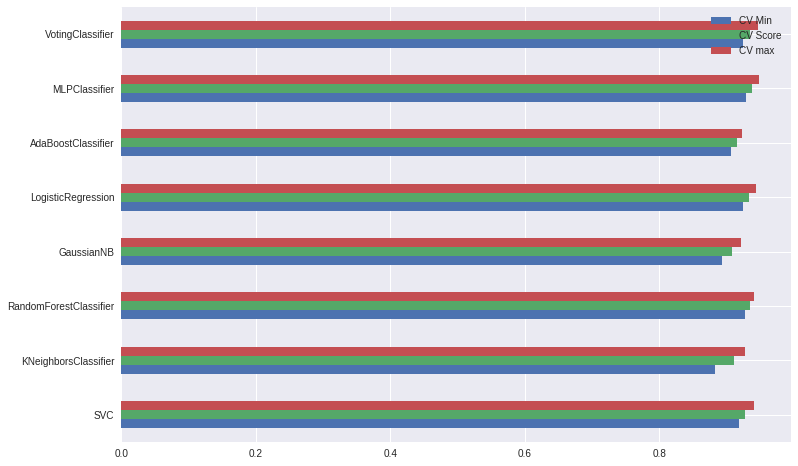

In [43]:
%%time
Benchmark(models,X_new,y,scoring='roc_auc')

##Model 2: Ensemble method with no outliers

####Voting classifier

In [0]:
X_new_ol=X_new[outliyers==1]
y_new_ol=y[outliyers==1]

#### Even after removing outliers dataset remains balanced

In [0]:
voting=[('nnet',MLPClassifier()),('rf',RandomForestClassifier(n_estimators=150,random_state=123,class_weight='balanced')),
        ('ada',AdaBoostClassifier(random_state=123)),('gnb',GaussianNB()),('lr',LogisticRegression(random_state=123)),
        ('svm',SVC(probability=True,random_state=123))]
Voting=VotingClassifier(estimators=voting,voting='soft')

models=[SVC(probability=True,random_state=123),KNeighborsClassifier(weights='distance'),RandomForestClassifier(n_estimators=150,random_state=123),
        GaussianNB(),LogisticRegression(random_state=123),AdaBoostClassifier(n_estimators=150,random_state=123),MLPClassifier(),Voting]

CPU times: user 30 s, sys: 10.9 s, total: 40.9 s
Wall time: 25.6 s


,CV Min,CV Score,CV max
SVC,0.917813,0.925908,0.938750
KNeighborsClassifier,0.881875,0.911429,0.931652
RandomForestClassifier,0.929174,0.934457,0.939219
GaussianNB,0.895893,0.907768,0.927902
LogisticRegression,0.926250,0.931592,0.940625
AdaBoostClassifier,0.880670,0.901696,0.914152
MLPClassifier,0.933036,0.937113,0.945134
VotingClassifier,0.928884,0.933795,0.943348


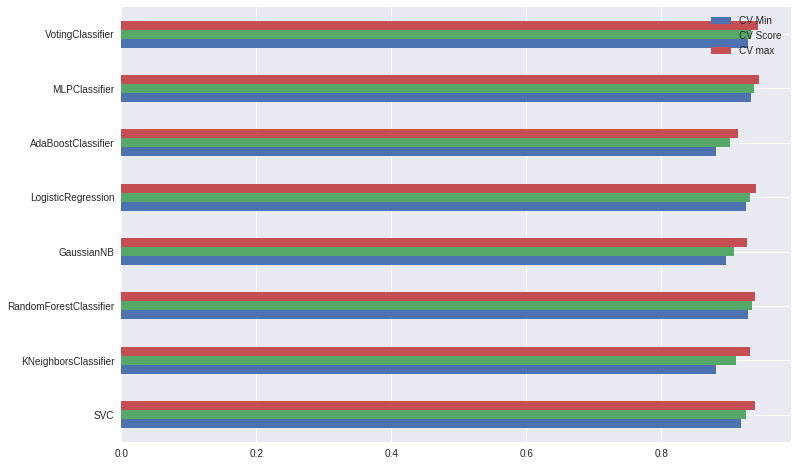

In [46]:
%%time
Benchmark(models,X_new_ol,y_new_ol,scoring='roc_auc')

##Model 3: Cluster based models:
>### By using clustering techniques, we will split the customers in order to perform a model based upon the specific characteristics of each cluster
>#### According to plots below k=2 is the optimal number of clusters to be kept since this number maximizes the siluhete score and  the  value that optimizes the inertia according to the "elbow rule"
>#### rightmost plot show the 2 clusters formed according to k means

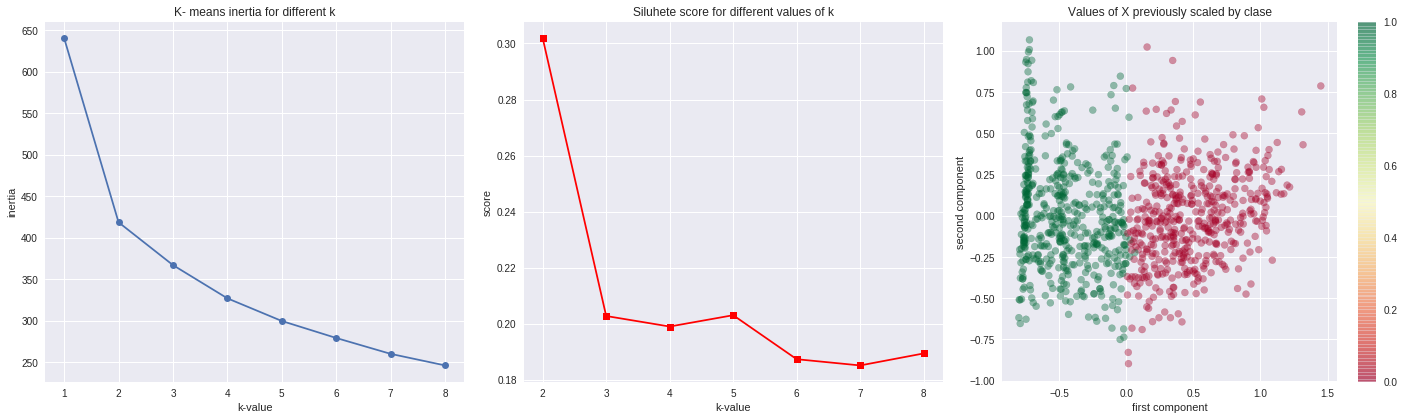

In [47]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
PlotK(X_new,8)
plt.subplot(1,3,2)
PlotClusterScore(X_new,8)
plt.subplot(1,3,3)
Plot2D(X_new,KMeans(n_clusters=2).fit(X_new).labels_)

## Modeling data from the 2 different clusters

In [0]:
labels=KMeans(n_clusters=2).fit(X_new).labels_

In [0]:
X_clust1=X_new[labels==0]
y_clust1=y[labels==0]
X_clust2=X_new[labels==1]
y_clust2=y[labels==1]

### Models on cluster 1

In [0]:
voting=[('nnet',MLPClassifier()),('rf',RandomForestClassifier(n_estimators=150,random_state=123,class_weight='balanced')),
        ('ada',AdaBoostClassifier(random_state=123)),('gnb',GaussianNB()),('lr',LogisticRegression(random_state=123)),
        ('svm',SVC(probability=True,random_state=123))]
Voting=VotingClassifier(estimators=voting,voting='soft')

models=[SVC(probability=True,random_state=123),KNeighborsClassifier(weights='distance'),RandomForestClassifier(n_estimators=150,random_state=123),
        GaussianNB(),LogisticRegression(random_state=123),AdaBoostClassifier(n_estimators=150,random_state=123),MLPClassifier(),Voting]

CPU times: user 19.6 s, sys: 7.19 s, total: 26.8 s
Wall time: 17 s


,CV Min,CV Score,CV max
SVC,0.903219,0.905256,0.906916
KNeighborsClassifier,0.806438,0.823990,0.841235
RandomForestClassifier,0.882340,0.891886,0.910070
GaussianNB,0.856024,0.867053,0.883428
LogisticRegression,0.890080,0.897969,0.902131
AdaBoostClassifier,0.820723,0.879490,0.925402
MLPClassifier,0.890170,0.896596,0.904089
VotingClassifier,0.897226,0.903736,0.910613


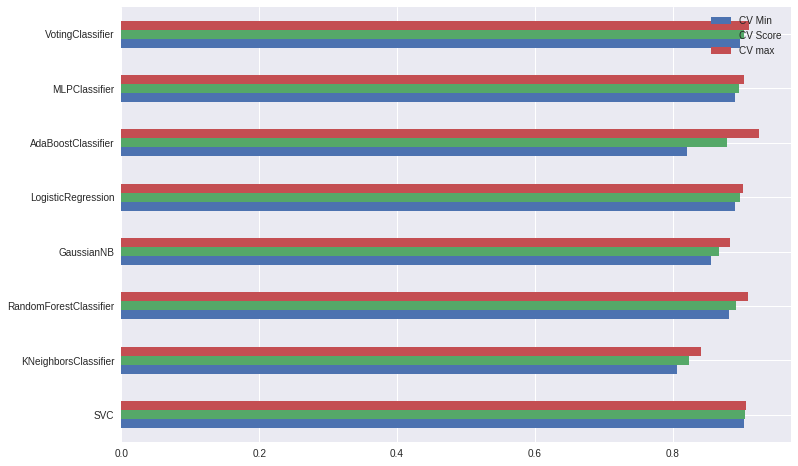

In [51]:
%%time

Benchmark(models,X_clust1,y_clust1,scoring='roc_auc',return_resultados=True)

###Models in cluster 2

CPU times: user 19.8 s, sys: 7.67 s, total: 27.5 s
Wall time: 17.3 s


,CV Min,CV Score,CV max
SVC,0.859091,0.887554,0.916597
KNeighborsClassifier,0.840476,0.870985,0.909454
RandomForestClassifier,0.851840,0.873162,0.887710
GaussianNB,0.769481,0.809575,0.857353
LogisticRegression,0.862121,0.885833,0.911555
AdaBoostClassifier,0.710084,0.773708,0.814286
MLPClassifier,0.857359,0.888893,0.915336
VotingClassifier,0.851515,0.880539,0.910294


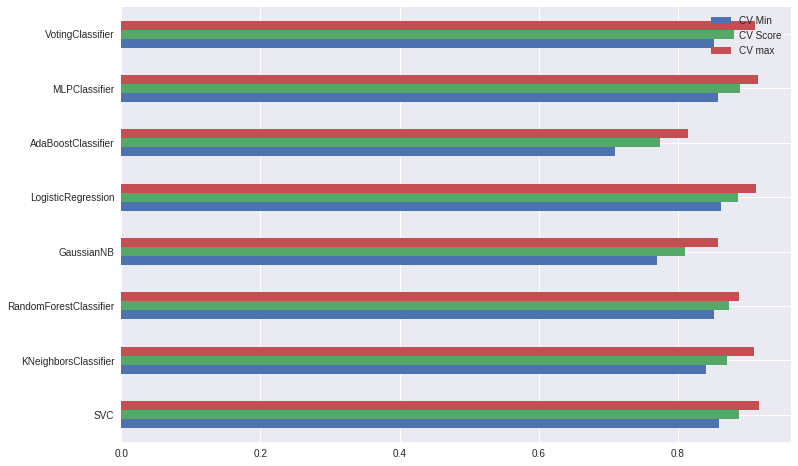

In [52]:
%%time

Benchmark(models,X_clust2,y_clust2,scoring='roc_auc',return_resultados=True)

##After this analysis the best model resulted to be Voting classifier over data with no outliers, so the last step will be "Parameters' tuning"

In [0]:
voting=[('nnet',MLPClassifier()),('rf',RandomForestClassifier(random_state=123,class_weight='balanced')),
        ('ada',AdaBoostClassifier(random_state=123)),('gnb',GaussianNB()),('lr',LogisticRegression(random_state=123)),
        ('svm',SVC(probability=True,random_state=123))]
Voting=VotingClassifier(estimators=voting,voting='soft')

In [0]:
params={'nnet__activation':['identity', 'logistic', 'tanh', 'relu'],'nnet__alpha':np.arange(.0001,.1,.05),'nnet__learning_rate':['constant', 'invscaling', 'adaptive'],
        'lr__C':np.arange(.01,1,.5),'rf__n_estimators':[150,250],'rf__criterion':['gini','entropy']}

grid=GridSearchCV(estimator=Voting,param_grid=params,scoring='roc_auc',cv=2)

In [55]:
%%time
grid.fit(X_new_ol,y_new_ol)

CPU times: user 9min 57s, sys: 4min 20s, total: 14min 17s
Wall time: 8min 22s


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=VotingClassifier(estimators=[('nnet', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=...=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'nnet__activation': ['identity', 'logistic', 'tanh', 'relu'], 'nnet__alpha': array([0.0001, 0.0501]), 'nnet__learning_rate': ['constant', 'invscaling', 'adaptive'], 'lr__C': array([0.01, 0.51]), 'rf__n_estimators': [150, 250], 'rf__criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

# Evaluation
### Roc auc score is chosen for evaluating model's performance for two main reasons:
>### Is easy to interprate and it is robust when triying to minimize false positives

###On the other hand we have chosen confusion matrix in order to have a complete landscape of model's performace and even we can calculate the cost/earnings derived from model if we have an estimated cost of false positives and false negatives

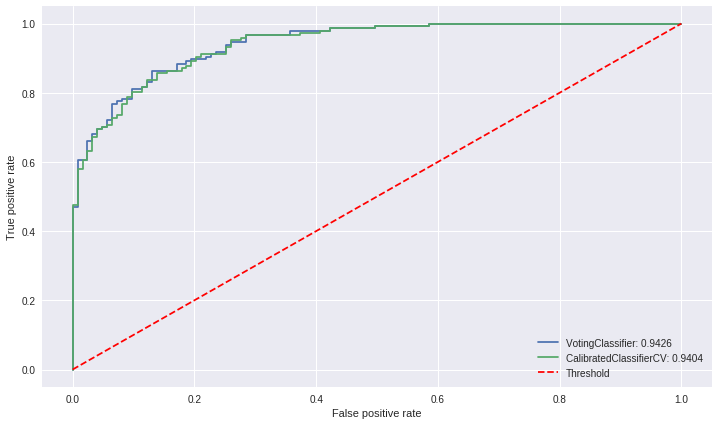

In [74]:
ROCs([grid.best_estimator_,CalibratedClassifierCV(base_estimator=grid.best_estimator_,method='sigmoid')],X_new_ol,y_new_ol)

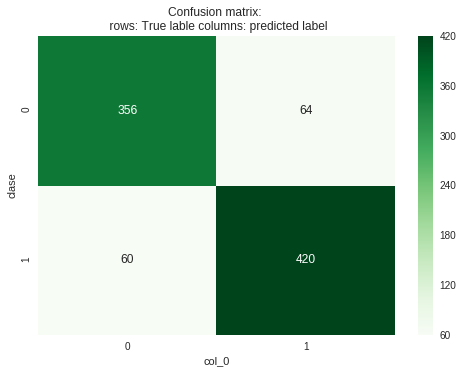

In [57]:
PlotConfusionMatrix(grid.best_estimator_,X_new_ol,y_new_ol)

##In order to construct a risk factor for each customer we are going to perform a calibration (Platt scaling) over our final classifier  to have probabilities associated to a customer

In [0]:
Final_model=CalibratedClassifierCV(base_estimator=grid.best_estimator_,method='sigmoid',cv=3).fit(X_new_ol,y_new_ol)
predictions=Final_model.predict_proba(X_new)[:,1]
users['predictions']=predictions


In [0]:
X_profiling=pd.concat([X_new,cliente_konfio,users.clase],axis=1)
X_profiling['risk_factor']=predictions
X_profiling['monthly_income']=users.monthly_income
X_profiling.drop('income',axis=1,inplace=True)
X_profiling=X_profiling[X_profiling.clase==1]

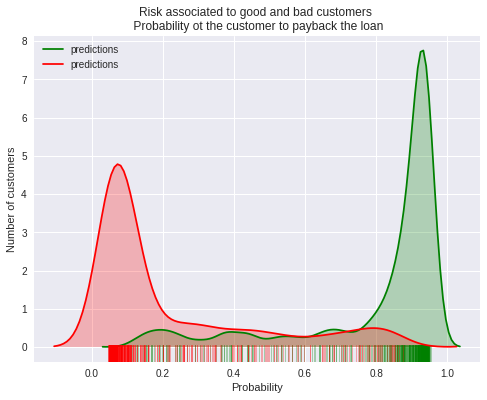

In [60]:
RiskPlot(users,'predictions','clase')

# Deployment


##To determine the amount to be loan to those clients marked as good we are going first to divide them into two groups: The ones that already have a credit with Konfio and the ones that not so that the decision rule will be as follows:
>### Konfio customers will be authorized  at most with 1.3 x monthly income multyplied by customer's risk (probability calculated with classification model)
>### Non customers will be autorized at most 1 x monthly income multyplied by customer's risk (probability calculated with classification model)


In [0]:
X_profiling_customers=X_profiling[X_profiling.has_credit_with_us==True]
X_profiling_customers['max_authorized_loan']=1.3*X_profiling_customers.monthly_income*X_profiling_customers.risk_factor

X_profiling_non_customers=X_profiling[X_profiling.has_credit_with_us==False]
X_profiling_non_customers['max_authorized_loan']=X_profiling_non_customers.monthly_income*X_profiling_non_customers.risk_factor

X_profiling_new=pd.concat([X_profiling_customers,X_profiling_non_customers],axis=0)

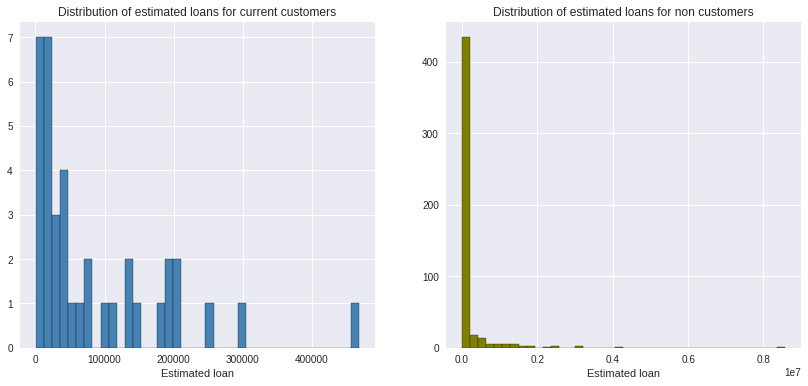

In [62]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
X_profiling_customers.max_authorized_loan.hist(bins=40,color='steelblue',edgecolor='black');
plt.title('Distribution of estimated loans for current customers')
plt.xlabel('Estimated loan')
plt.subplot(1,2,2)
X_profiling_non_customers.max_authorized_loan.hist(bins=40,color='olive',edgecolor='black');
plt.title('Distribution of estimated loans for non customers')
plt.xlabel('Estimated loan');

## To determine rate of interest associated to each loan we will use the information provided by business applied to customer's risk as follows:
>### We already know that rate of interest is between  28% & 59% so the customers with a higher risk will have a smaller rate. With this in mind we are going to train a neural net to predict values between the range (28%,59%) based on risk factor calculated previously with our classifier model

In [0]:
axis=np.linspace(start=.28,stop=.60,num=X_profiling.shape[0])

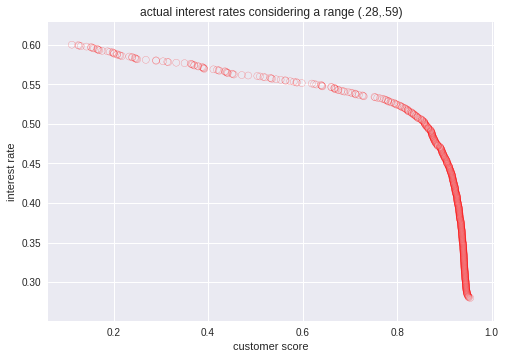

In [64]:
plt.scatter(y=axis,x=X_profiling_new.risk_factor.sort_values(ascending=False),facecolor='none',edgecolor='red',alpha=.5)
plt.xlabel('customer score')
plt.ylabel('interest rate');
plt.title('actual interest rates considering a range (.28,.59)');

In [0]:
n=X_profiling.shape[0]
x=X_profiling_new.risk_factor.sort_values(ascending=False)
y=axis
X = np.reshape(x ,[n, 1]) 
y = np.reshape(y ,[n ,])
modelo =MLPRegressor(hidden_layer_sizes=(1000,500,2000,1000,1000)).fit(X,y) # We know this model is overfitted but this time this is waht we want since we are practiclly perforing an interpolaton for the values on the range (.28,.59)

In [0]:
predicted_rate=modelo.predict(np.reshape(X_profiling_new.risk_factor,[n, 1]))
X_profiling_new['estimated_interest_rate']=predicted_rate

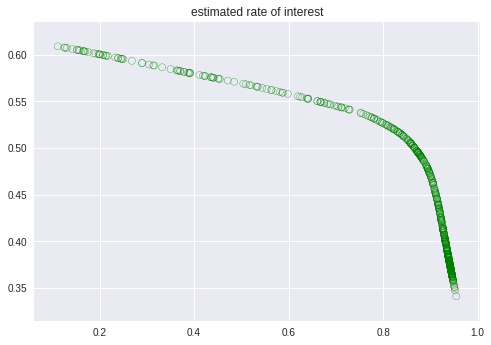

In [67]:
plt.scatter(data=X_profiling_new,x='risk_factor',y='estimated_interest_rate',facecolor='none',edgecolor='green')
plt.title('estimated rate of interest');

##Finally to calculate loan's term we are going to apply the following formula: n= C/(P-C x i) such that:
>### n: term of payments to be estimated
>### C: maximum_authorized amount (previously calculated)
>### P: 10% of monthly income, this comes because 'ratio' for the 75% of the customers is below 11% so this is the percentage that a customer can affort as new debt*



##### *See table below



In [68]:
X_profiling.ratio.describe()

count    535.000000
mean       0.091170
std        0.098575
min        0.000012
25%        0.034314
50%        0.072222
75%        0.110390
max        0.967087
Name: ratio, dtype: float64

In [0]:
X_profiling_new['loan_term_months']=round(X_profiling_new.max_authorized_loan/(X_profiling_new.monthly_income*.10-X_profiling_new.max_authorized_loan*(X_profiling_new.estimated_interest_rate/12)))

Text(0.5, 1.0, "distribution of loan's term")

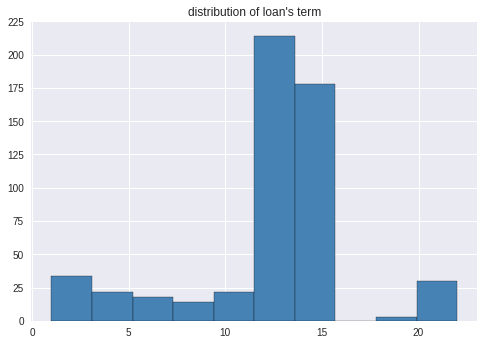

In [70]:
X_profiling_new.loan_term_months.hist(bins=10,color='steelblue',edgecolor='black')
plt.title("distribution of loan's term")

#Finally we are on position to provide a table for the 524 customers market as good ones wich contains:
>## User risk (the higher the better)
>## Maximum proposed amount of loan
>## Term
>## Interest rate

In [0]:
Final_=X_profiling_new[['risk_factor','max_authorized_loan','loan_term_months', 'estimated_interest_rate']]

In [72]:
Final_.head(10)

,risk_factor,max_authorized_loan,loan_term_months,estimated_interest_rate
0,0.916533,304258.423092,21.0,0.439238
27,0.945723,196655.024831,20.0,0.362967
32,0.864796,196415.077940,21.0,0.501120
70,0.938456,130758.888155,20.0,0.381819
87,0.890562,31210.103160,22.0,0.481857
90,0.913441,134517.046914,21.0,0.445929
112,0.936571,14851.586649,20.0,0.386765
148,0.249984,37967.903097,4.0,0.595423
160,0.667533,19212.081007,14.0,0.549455
178,0.940091,142640.733804,20.0,0.377532
